# Xgboost

In [1]:
! pip install xgboost
! pip install shap
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from maccs_keys_descriptions import maccs_keys_descriptions


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# load data and compute maccs keys

In [3]:
def compute_MACCS_keys(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return list(MACCSkeys.GenMACCSKeys(mol).ToBitString())

# read CSV file
df = pd.read_csv('./Data/logP_labels.csv',index_col=0)

# split into train, validation, and test sets and use the same random state wiht molecular graph model
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.111, random_state=42)

In [5]:
def compute_MACCS(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return MACCSkeys.GenMACCSKeys(mol).ToBitString()

def convert_MACCS_to_list(maccs_str):
    return [int(bit) for bit in maccs_str]

def convert_string_to_list(string):
    return ast.literal_eval(string)

In [ ]:
# compute MACCS keys
train_df['MACCS'] = train_df['SMILES'].apply(compute_MACCS)
val_df['MACCS'] = val_df['SMILES'].apply(compute_MACCS)
test_df['MACCS'] = test_df['SMILES'].apply(compute_MACCS)

train_df['MACCS'] = train_df['MACCS'].apply(convert_MACCS_to_list)
val_df['MACCS'] = val_df['MACCS'].apply(convert_MACCS_to_list)
test_df['MACCS'] = test_df['MACCS'].apply(convert_MACCS_to_list)

# save MACCS keys
train_df.to_csv('./Data/train_maccs.csv', index=False)
val_df.to_csv('./Data/val_maccs.csv', index=False)
test_df.to_csv('./Data/test_maccs.csv', index=False)

In [6]:
# load MACCS keys
train_df = pd.read_csv('./Data/train_maccs.csv')
val_df = pd.read_csv('./Data/val_maccs.csv')
test_df = pd.read_csv('./Data/test_maccs.csv')

train_df['MACCS'] = train_df['MACCS'].apply(convert_string_to_list)
val_df['MACCS'] = val_df['MACCS'].apply(convert_string_to_list)
test_df['MACCS'] = test_df['MACCS'].apply(convert_string_to_list)


# Train Xgboost model

In [7]:
# split into X and y
X_train = list(train_df['MACCS'])
y_train = train_df['Kow'].values
X_val = list(val_df['MACCS'])
y_val = val_df['Kow'].values
X_test = list(test_df['MACCS'])
y_test = test_df['Kow'].values

# train model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {"objective": "reg:squarederror"}
model = xgb.train(params, dtrain, evals=[(dval, "Val")], num_boost_round=100)

# make predictions
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)


[0]	Val-rmse:1.94547
[1]	Val-rmse:1.61930
[2]	Val-rmse:1.41435
[3]	Val-rmse:1.27138
[4]	Val-rmse:1.17278
[5]	Val-rmse:1.10217
[6]	Val-rmse:1.05789
[7]	Val-rmse:1.01074
[8]	Val-rmse:0.97422
[9]	Val-rmse:0.94822
[10]	Val-rmse:0.92149
[11]	Val-rmse:0.90404
[12]	Val-rmse:0.88303
[13]	Val-rmse:0.86894
[14]	Val-rmse:0.85980
[15]	Val-rmse:0.85028
[16]	Val-rmse:0.84236
[17]	Val-rmse:0.83680
[18]	Val-rmse:0.82923
[19]	Val-rmse:0.82226
[20]	Val-rmse:0.81778
[21]	Val-rmse:0.81002
[22]	Val-rmse:0.80598
[23]	Val-rmse:0.79922
[24]	Val-rmse:0.79281
[25]	Val-rmse:0.78791
[26]	Val-rmse:0.78347
[27]	Val-rmse:0.78026
[28]	Val-rmse:0.77409
[29]	Val-rmse:0.77104
[30]	Val-rmse:0.76671
[31]	Val-rmse:0.76281
[32]	Val-rmse:0.76192
[33]	Val-rmse:0.76003
[34]	Val-rmse:0.75820
[35]	Val-rmse:0.75650
[36]	Val-rmse:0.75160
[37]	Val-rmse:0.74948
[38]	Val-rmse:0.74739
[39]	Val-rmse:0.74473
[40]	Val-rmse:0.74235
[41]	Val-rmse:0.73957
[42]	Val-rmse:0.73946
[43]	Val-rmse:0.73751
[44]	Val-rmse:0.73573
[45]	Val-rmse:0.7341

# test model in test set

R² on test set: 0.8333553877733026


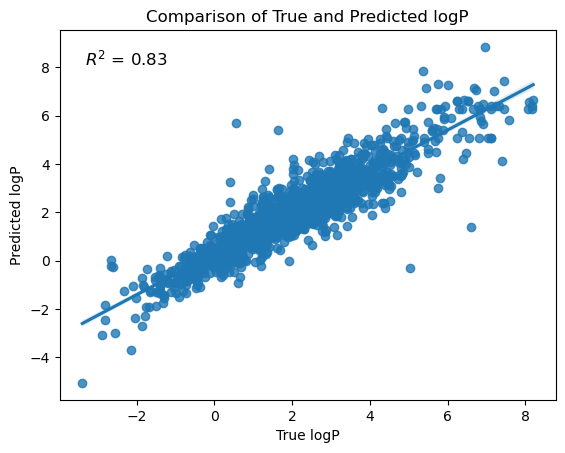

In [21]:
y_true=y_test
r2 = r2_score(y_true, y_pred)
print(f'R² on test set: {r2}')

sns.regplot(x=y_true, y=y_pred)
plt.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', fontsize=12, va='top', transform=plt.gca().transAxes)
plt.xlabel('True logP')
plt.ylabel('Predicted logP')
plt.title('Comparison of True and Predicted logP')

plt.savefig('./Result/Xgboost_test_r2.png')

# Use shap to analysis the importance of features

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


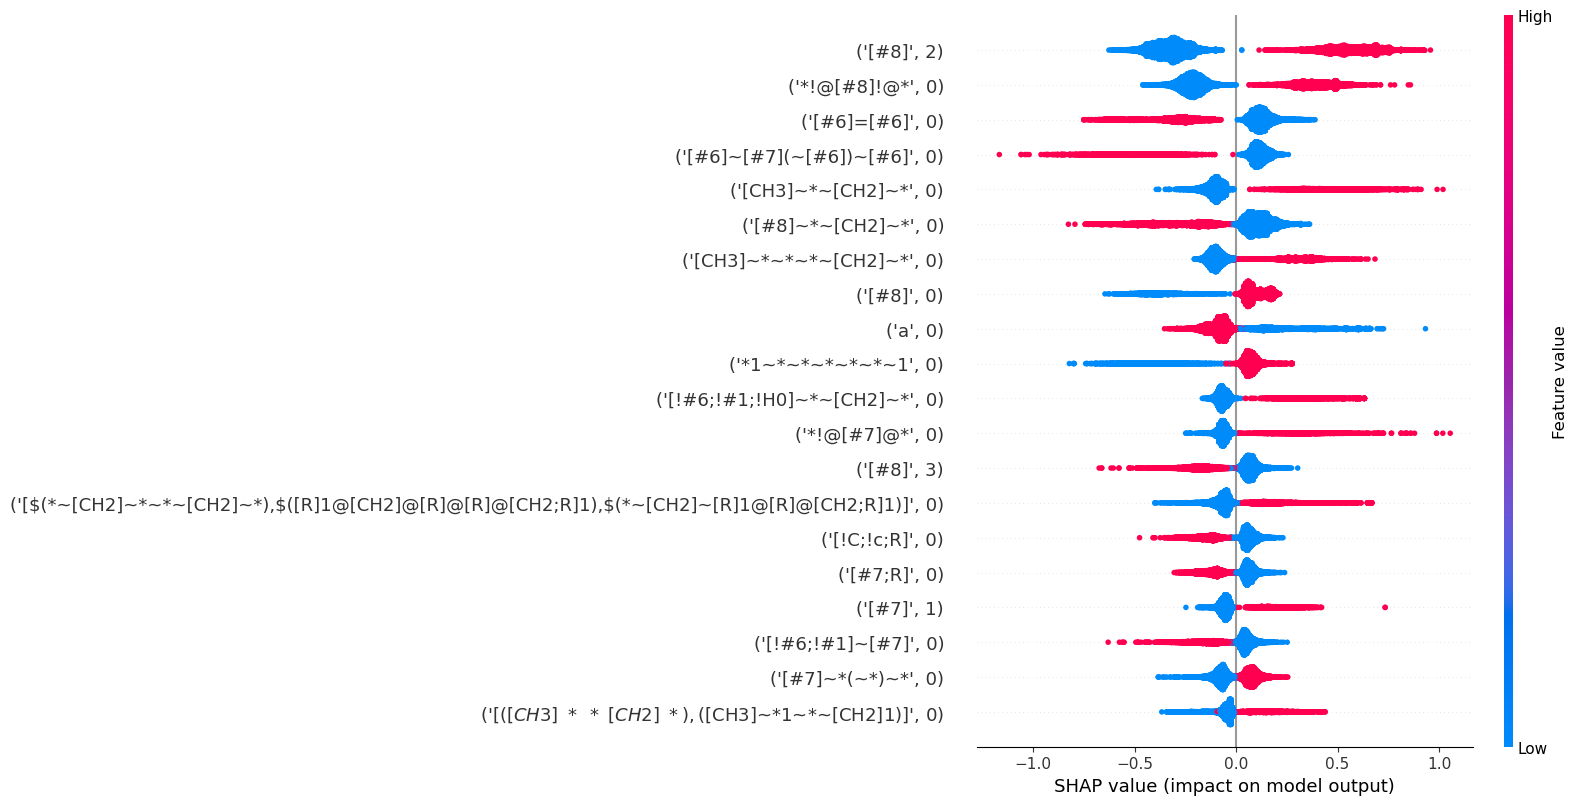

In [9]:
x_value=np.array(X_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_value)

# get feature names
feature_names = [maccs_keys_descriptions.get(i + 1) for i in range(len(x_value[0]))]

plt.figure()
shap.summary_plot(shap_values, features=x_value, feature_names=feature_names,show=False)
plt.savefig('./Result/Xgboost_shap.png')
